In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization  # Fixed import
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

In [5]:
# Load dataset
df = pd.read_csv('stroop_test.csv')
print("Original Dataset:")
print(df.head())
df.describe()

Original Dataset:
   Participant  Accuracy(%)  ReactionTime(min)
0            1           36               0.48
1            2           75               2.33
2            3           89               2.42
3            4           69               1.32
4            5           56               0.32


,Participant,Accuracy(%),ReactionTime(min)
count,50.00000,50.000000,50.000000
mean,25.50000,65.440000,1.508200
std,14.57738,20.814202,0.793853
min,1.00000,31.000000,0.200000
25%,13.25000,49.000000,1.072500
50%,25.50000,67.500000,1.465000
75%,37.75000,85.250000,2.282500
max,50.00000,98.000000,3.000000


In [6]:
#labeling-
def label_data(row):
    """Classify based on accuracy and reaction time thresholds"""
    if row['Accuracy(%)'] >= 70 and row['ReactionTime(min)'] <= 1.5:
        return 0  # Low cognitive interference
    return 1       # High cognitive interference

df['Interference'] = df.apply(label_data, axis=1)
print("\nLabeled Dataset:")
print(df.head())
print("\nClass Distribution:")
print(df['Interference'].value_counts())


Labeled Dataset:
   Participant  Accuracy(%)  ReactionTime(min)  Interference
0            1           36               0.48             1
1            2           75               2.33             1
2            3           89               2.42             1
3            4           69               1.32             1
4            5           56               0.32             1

Class Distribution:
Interference
1    48
0     2
Name: count, dtype: int64


In [7]:
# Statistical Features
stats_features = {
    '1. Accuracy Mean': df['Accuracy(%)'].mean(),
    '2. Reaction Time Mean': df['ReactionTime(min)'].mean(),
    '3. Accuracy Std Dev': df['Accuracy(%)'].std(),
    '4. Reaction Time Std Dev': df['ReactionTime(min)'].std(),
    '5. Accuracy-Reaction Correlation': df['Accuracy(%)'].corr(df['ReactionTime(min)']),
    '6. Min Accuracy': df['Accuracy(%)'].min(),
    '7. Max Accuracy': df['Accuracy(%)'].max(),
    '8. Min Reaction Time': df['ReactionTime(min)'].min(),
    '9. Max Reaction Time': df['ReactionTime(min)'].max(),
    '10. Accuracy Skewness': df['Accuracy(%)'].skew(),
    '11. Reaction Time Kurtosis': df['ReactionTime(min)'].kurtosis(),
    '12. Low Interference Percentage': (df['Interference'] == 0).mean() * 100
}

print("\nStatistical Features:")
for feature, value in stats_features.items():
    print(f"{feature}: {value:.4f}")


Statistical Features:
1. Accuracy Mean: 65.4400
2. Reaction Time Mean: 1.5082
3. Accuracy Std Dev: 20.8142
4. Reaction Time Std Dev: 0.7939
5. Accuracy-Reaction Correlation: 0.8794
6. Min Accuracy: 31.0000
7. Max Accuracy: 98.0000
8. Min Reaction Time: 0.2000
9. Max Reaction Time: 3.0000
10. Accuracy Skewness: -0.1347
11. Reaction Time Kurtosis: -0.9805
12. Low Interference Percentage: 4.0000


In [25]:
# Data Preparation
X = df[['Accuracy(%)', 'ReactionTime(min)']]
y = df['Interference']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Feature Scaling (for neural network)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


ENHANCED NEURAL NETWORK


/Users/rokibulislam/Documents/GitHub/Rokibul_2111088642_CSE445/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Neural Network Results:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        13

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



/Users/rokibulislam/Documents/GitHub/Rokibul_2111088642_CSE445/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


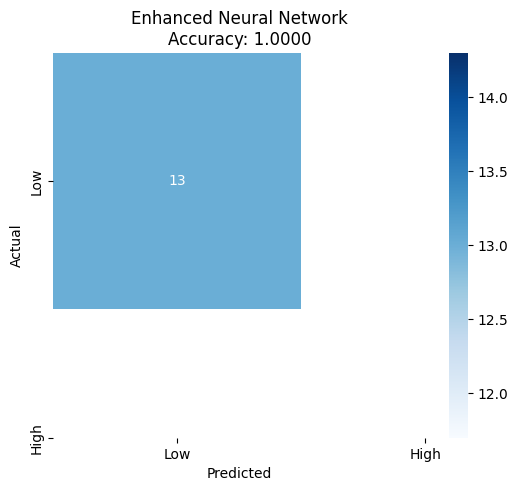

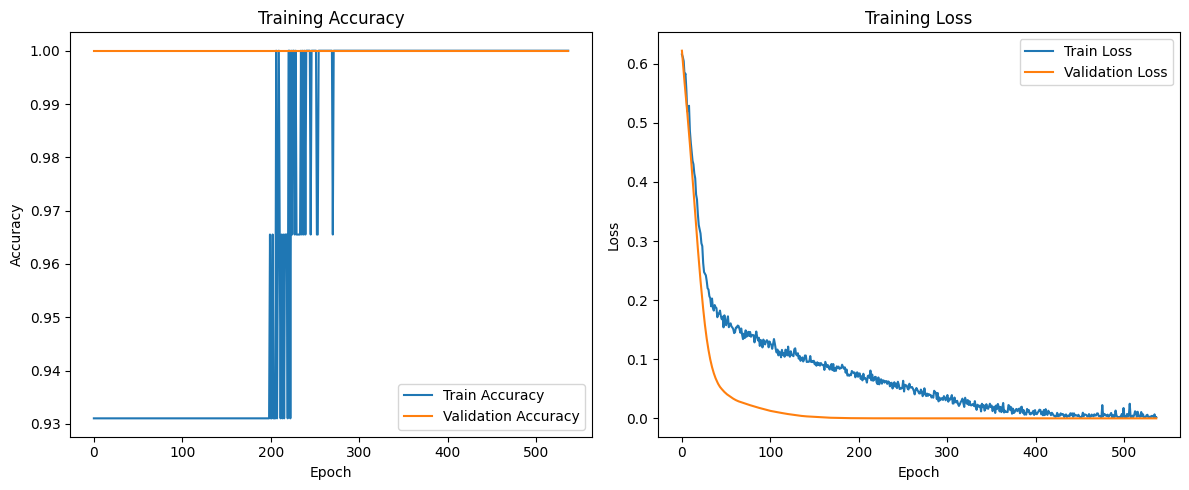

In [27]:
# Neural Network 
print("\n" + "="*60)
print("ENHANCED NEURAL NETWORK")
print("="*60)

# Create robust model without batch normalization
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile with custom optimizer
optimizer = Adam(learning_rate=0.0005)
nn_model.compile(optimizer=optimizer, 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train model
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=1000,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Evaluate model
nn_probs = nn_model.predict(X_test_scaled)
nn_pred = (nn_probs > 0.5).astype(int)
nn_acc = accuracy_score(y_test, nn_pred)

# Print results
print("\nNeural Network Results:")
print(f"Accuracy: {nn_acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, nn_pred))

# Confusion Matrix
nn_cm = confusion_matrix(y_test, nn_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'High'], 
            yticklabels=['Low', 'High'])
plt.title(f'Enhanced Neural Network\nAccuracy: {nn_acc:.4f}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('neural_network_cm.png')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('nn_training_history.png')
plt.show()



OPTIMIZED RANDOM FOREST


/Users/rokibulislam/Documents/GitHub/Rokibul_2111088642_CSE445/venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package o


Random Forest Results:
Best Parameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



/Users/rokibulislam/Documents/GitHub/Rokibul_2111088642_CSE445/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


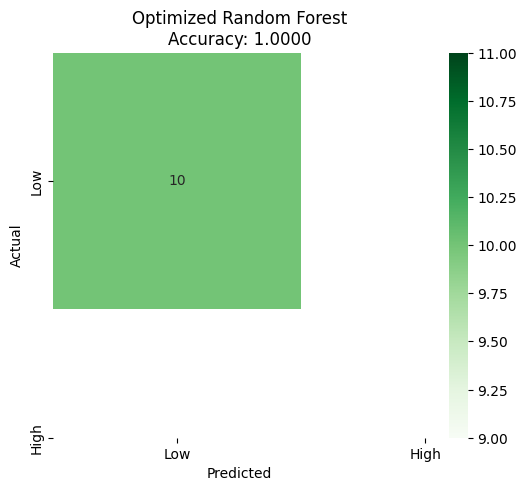

/var/folders/rw/78tm6n2d2856gsqb273p1x2h0000gn/T/ipykernel_82624/3794698331.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importance, y=features, palette='viridis')


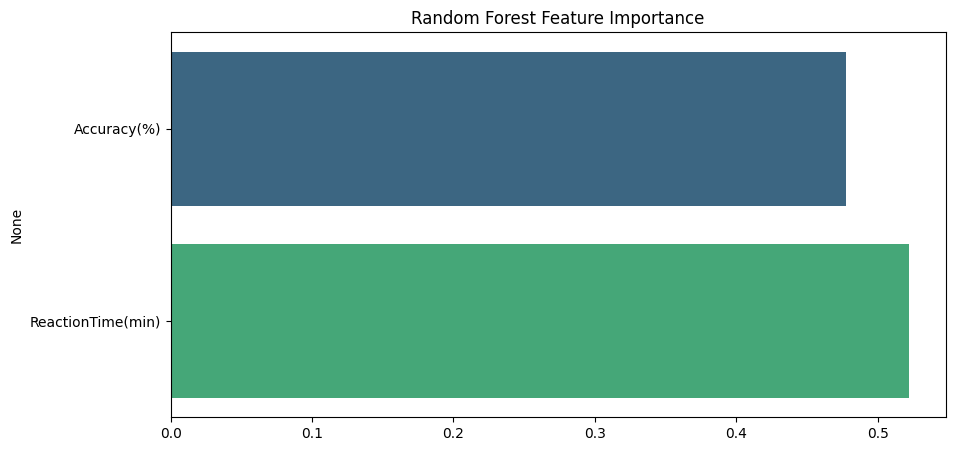

In [21]:

# Random Forest

print("\n" + "="*60)
print("OPTIMIZED RANDOM FOREST")
print("="*60)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [8, 15, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Grid search with cross-validation
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

# Get best model
rf_model = rf_grid.best_estimator_
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

# Print results
print("\nRandom Forest Results:")
print(f"Best Parameters: {rf_grid.best_params_}")
print(f"Accuracy: {rf_acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, rf_pred))

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Low', 'High'], 
            yticklabels=['Low', 'High'])
plt.title(f'Optimized Random Forest\nAccuracy: {rf_acc:.4f}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('random_forest_cm.png')
plt.show()

# Feature importance
rf_importance = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 5))
sns.barplot(x=rf_importance, y=features, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.savefig('rf_feature_importance.png')
plt.show()


BOOSTED XGBOOST


/Users/rokibulislam/Documents/GitHub/Rokibul_2111088642_CSE445/venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package o


XGBoost Results:
Best Parameters: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.7}
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



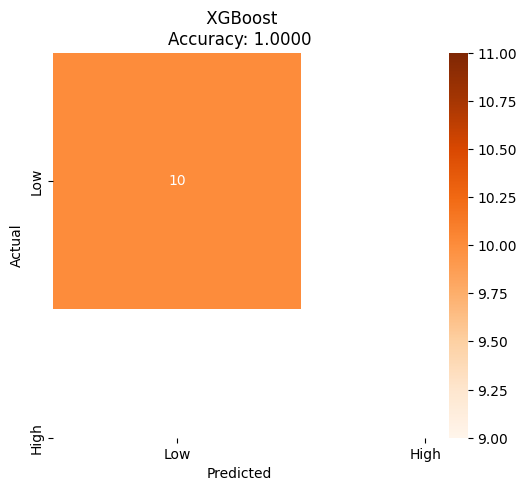

/var/folders/rw/78tm6n2d2856gsqb273p1x2h0000gn/T/ipykernel_82624/809298875.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importance, y=features, palette='magma')


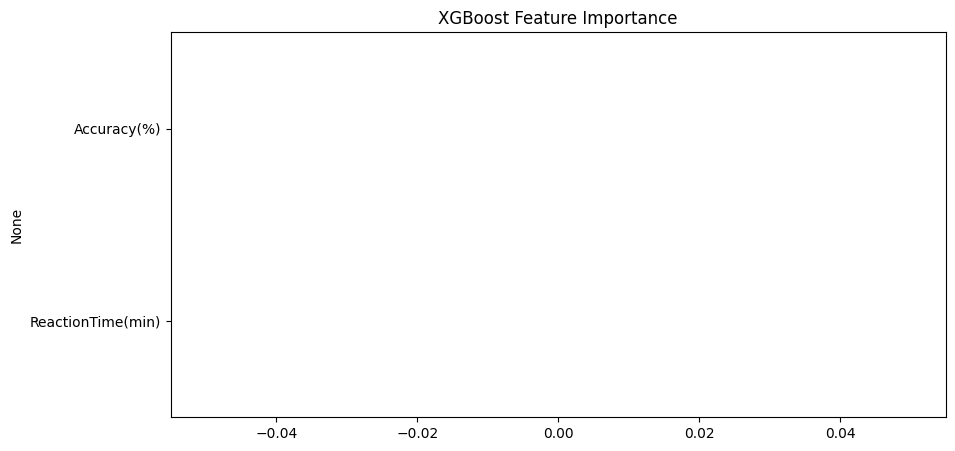

In [24]:

# XGBoost

print("\n" + "="*60)
print("BOOSTED XGBOOST")
print("="*60)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# Grid search with cross-validation
xgb_grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)

# Get best model
xgb_model = xgb_grid.best_estimator_
xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)

# Print results
print("\nXGBoost Results:")
print(f"Best Parameters: {xgb_grid.best_params_}")
print(f"Accuracy: {xgb_acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, xgb_pred))

# Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Low', 'High'], 
            yticklabels=['Low', 'High'])
plt.title(f' XGBoost\nAccuracy: {xgb_acc:.4f}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('xgboost_cm.png')
plt.show()

# Feature importance
xgb_importance = xgb_model.feature_importances_
plt.figure(figsize=(10, 5))
sns.barplot(x=xgb_importance, y=features, palette='magma')
plt.title('XGBoost Feature Importance')
plt.savefig('xgb_feature_importance.png')
plt.show()



FINAL MODEL COMPARISON

Model Performance Comparison:
Enhanced Neural Network: 1.0000
Optimized Random Forest: 1.0000
Boosted XGBoost: 1.0000


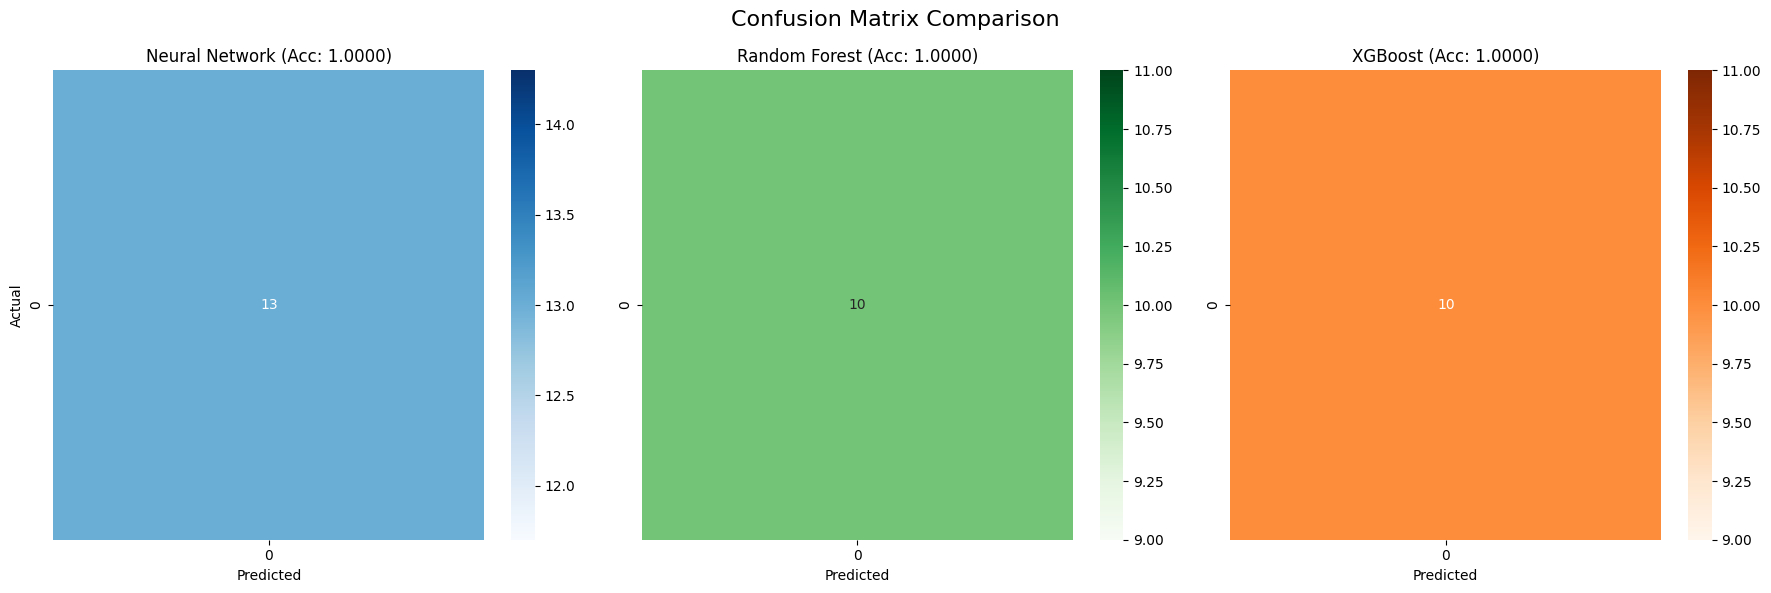

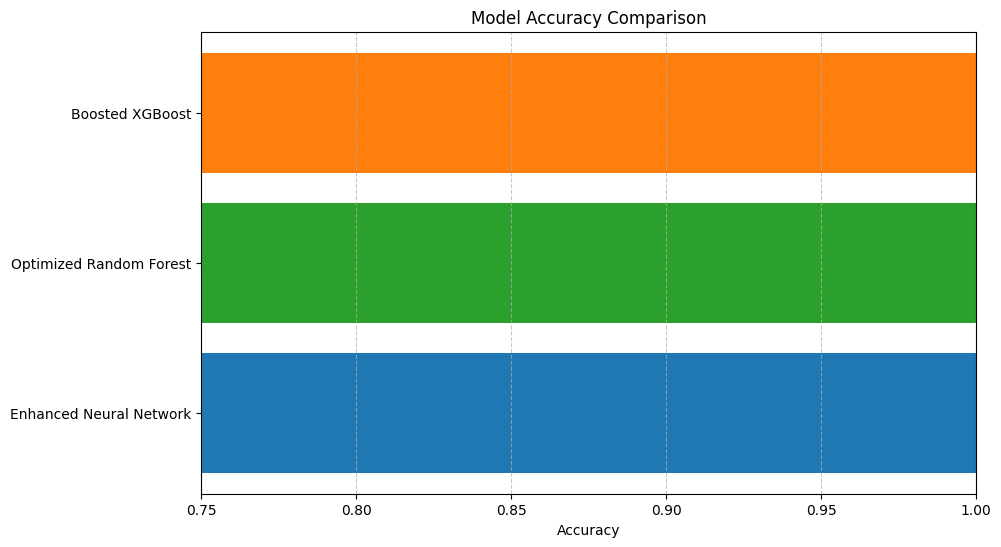

In [28]:

# Model Comparison

print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)

# Compare model performance
results = {
    "Enhanced Neural Network": nn_acc,
    "Optimized Random Forest": rf_acc,
    "Boosted XGBoost": xgb_acc
}

print("\nModel Performance Comparison:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

# Create composite confusion matrix plot
plt.figure(figsize=(18, 6))

# Neural Network
plt.subplot(1, 3, 1)
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Neural Network (Acc: {nn_acc:.4f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Random Forest
plt.subplot(1, 3, 2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens')
plt.title(f'Random Forest (Acc: {rf_acc:.4f})')
plt.ylabel('')
plt.xlabel('Predicted')

# XGBoost
plt.subplot(1, 3, 3)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Oranges')
plt.title(f'XGBoost (Acc: {xgb_acc:.4f})')
plt.ylabel('')
plt.xlabel('Predicted')

plt.suptitle('Confusion Matrix Comparison', fontsize=16)
plt.tight_layout()
plt.savefig('final_confusion_matrices.png')
plt.show()

# Performance comparison chart
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color=['#1f77b4', '#2ca02c', '#ff7f0e'])
plt.xlim(0.75, 1.0)
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('final_model_comparison.png')
plt.show()



# data showcase

/var/folders/rw/78tm6n2d2856gsqb273p1x2h0000gn/T/ipykernel_82624/137625536.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rw/78tm6n2d2856gsqb273p1x2h0000gn/T/ipykernel_82624/137625536.py:87: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


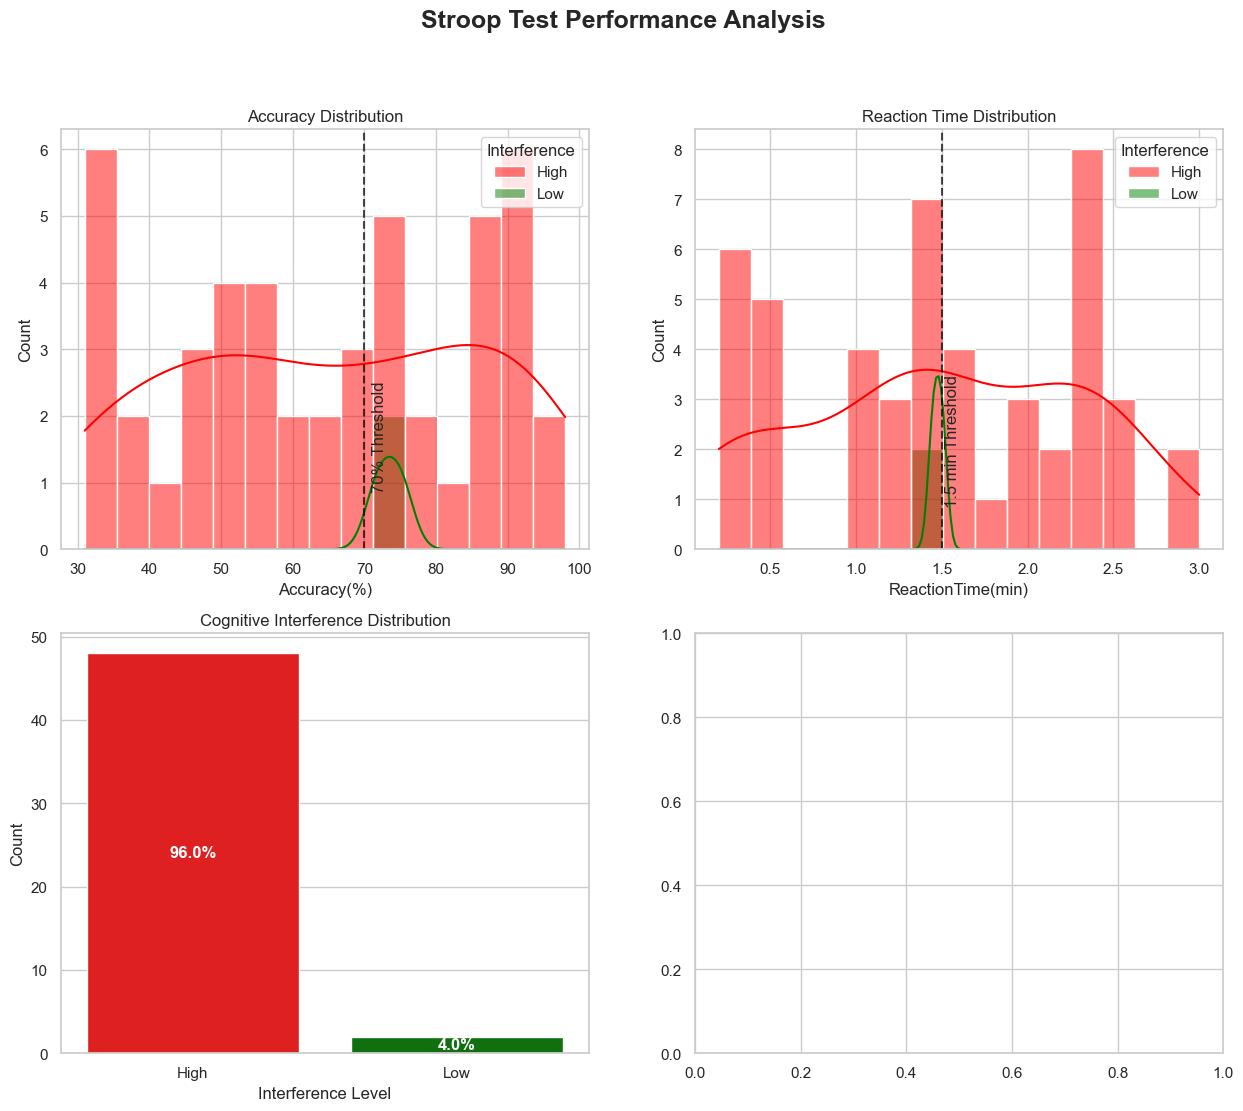

<Figure size 1000x800 with 0 Axes>

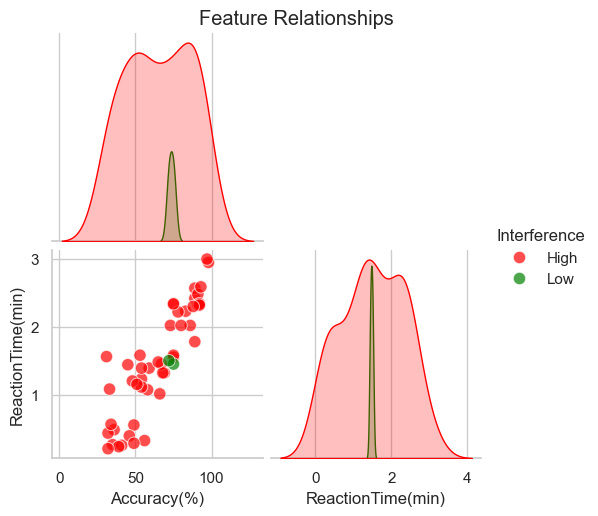

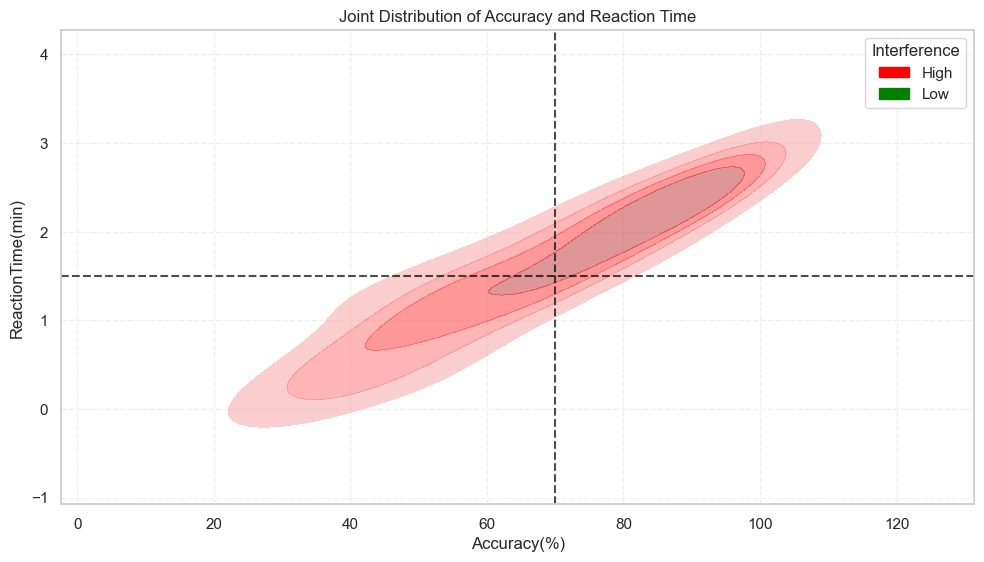

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="whitegrid")

df = pd.read_csv('stroop_test.csv')


df['Interference'] = df.apply(
    lambda row: 'Low' if row['Accuracy(%)'] >= 70 and row['ReactionTime(min)'] <= 1.5 else 'High', 
    axis=1
)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Stroop Test Performance Analysis', fontsize=18, fontweight='bold')

# 1. Accuracy Distribution (Histplot)

sns.histplot(
    data=df, 
    x='Accuracy(%)', 
    kde=True, 
    hue='Interference',
    palette={'Low': 'green', 'High': 'red'},
    bins=15,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Accuracy Distribution')
axes[0, 0].axvline(70, color='black', linestyle='--', alpha=0.7)
axes[0, 0].text(71, plt.ylim()[1]*0.9, '70% Threshold', rotation=90)

# 2. Reaction Time Distribution (Histplot)

sns.histplot(
    data=df, 
    x='ReactionTime(min)', 
    kde=True, 
    hue='Interference',
    palette={'Low': 'green', 'High': 'red'},
    bins=15,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Reaction Time Distribution')
axes[0, 1].axvline(1.5, color='black', linestyle='--', alpha=0.7)
axes[0, 1].text(1.52, plt.ylim()[1]*0.9, '1.5 min Threshold', rotation=90)

# 3. Interference Class Distribution (Bar Chart)

class_counts = df['Interference'].value_counts()
sns.barplot(
    x=class_counts.index, 
    y=class_counts.values, 
    palette={'High': 'red', 'Low': 'green'},
    ax=axes[1, 0]
)
axes[1, 0].set_title('Cognitive Interference Distribution')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xlabel('Interference Level')

total = len(df)
for i, count in enumerate(class_counts):
    percentage = f'{(count/total)*100:.1f}%'
    axes[1, 0].text(i, count/2, percentage, 
                   ha='center', va='center', 
                   fontsize=12, fontweight='bold', color='white')

# 4. Pairplot (Relationships between variables)

plt.figure(figsize=(10, 8))
pair = sns.pairplot(
    data=df,
    vars=['Accuracy(%)', 'ReactionTime(min)'],
    hue='Interference',
    palette={'Low': 'green', 'High': 'red'},
    diag_kind='kde',
    corner=True,
    plot_kws={'s': 80, 'alpha': 0.7}
)
pair.fig.suptitle('Feature Relationships', y=1.02)
plt.savefig('pairplot.png', bbox_inches='tight')

# 5. Combined Distribution (KDE Plot)

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df,
    x='Accuracy(%)',
    y='ReactionTime(min)',
    hue='Interference',
    palette={'Low': 'green', 'High': 'red'},
    fill=True,
    alpha=0.5,
    levels=5,
    thresh=0.2
)
plt.axhline(1.5, color='black', linestyle='--', alpha=0.7)
plt.axvline(70, color='black', linestyle='--', alpha=0.7)
plt.title('Joint Distribution of Accuracy and Reaction Time')
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig('joint_distribution.png', bbox_inches='tight')

# Adjust layout and save
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('stroop_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()